# Análise da métrica "Preços dos Itens" de um projeto cultural
---

**Objetivo:** realizar uma análise comparativa entre a porcentagem de preços de itens outliers de todos os projetos culturais de um mesmo segmento.

Para detectar anomalias/outliers serão utilizadas diversas estratégias, tanto de modelos de distribuição para aproximar a PDF (Probability Density Function) da RV (Random Variable) gerada pela métrica, quanto as baseadas em amostras, como é o caso do detector de outlier LOF (Local Outlier Factor).

Issue relacionada ao estudo:
* [#174](https://github.com/lappis-unb/salic-ml/issues/174)

Documentação relacionada:
* \[[link](https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira)\] Brainstorming de features para estimar a Complexidade Financeira

## Metodologia

Foram aplicados cinco modelos de detecção de anomalias: quatro baseados na aproximação da Função de Densidade de Probabilidade (PDF) e um baseado na exploração da densidade de amostras ao redor de um ponto específico (LOF). 

Para todos os modelos, a estratégia seguida foi a mesma. Primeiramente, dividiu-se o conjunto amostral em conjunto de treinamento (70% dos dados) e conjunto de teste (os 30% restantes dos dados).
Em seguida, cada um dos modelos foi treinado com o conjunto de treinamento, supondo uma taxa de contaminação fixa de 10% das amostras (contaminação é a taxa de outliers contidos na amostra).
O conjunto de testes foi passado a cada modelo, que retornou a relação de amostras rotuladas como inliers/outliers. Os tempos de treinamento e teste foram anotados e criou-se uma figura contendo dois histogramas, um para os inliers e um para os outliers.
Além disso, a métrica de contaminação encontrada foi levantada para comparar a eficiência de cada um dos cinco modelos.

#### Detecção de anomalias baseada na aproximação da PDF por modelos de distribuição

A PDF dos dados observados foi ajustada às seguintes distribuições:

* Distribuição Gaussiana;
* Distribuição Log-Normal;
* Distribuição Gamma;
* Estimação de Distribuição por Kernel Gaussiano (KDE).

O treinamento de todos os quatro modelos de distribuição consiste em ajustar a curva ao conjunto de treinamento e então encontrar, via bisseção, um limiar de densidade de probabilidade $p$, tal que, dada uma taxa de contaminação $c$, a igualdade abaixo é satisfeita:

$$ c = \int_{\forall x \ \vert \ f_X(x) < p}f_X(x)dx $$

Onde $f_X$ é a PDF encontrada ao ajustar cada uma das distribuições utilizadas.

Para verificar se uma nova amostra $x$ é um inlier ou um outlier, basta verificar se $f_X(x) \geq p$ ou $f_X(x) < p$, respectivamente, ou seja, $x$ é outlier se ele é pouco provável de acontecer, segundo a distribuição utilizada.

#### Detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico

O último modelo utilizado foi o _Local Outlier Factor_ (LOF), que verifica se uma amostra é um outlier ao comparar a densidade de amostras ao seu redor com a densidade de amostras de suas vizinhas. Caso uma amostra tenha densidade muito menor que suas vizinhas, ela é considerada um outlier.

O treinamento do LOF utiliza o `OutlierDetection` da classe `sklearn.neighbors.LocalOutlierFactor` para verificar quais são os outliers do conjunto de treinamento, passando a contaminação como parâmetro. Em seguida, os outliers são retirados do conjunto de treinamento e o LOF em si é treinado utilizando o `NoveltyDetection` da mesma classe.

Para verificar se uma nova amostra $x$ é um inlier ou um outlier, basta utilizar a função `predict` da `NoveltyDetection` para verificar se tal amostra tem uma densidade de amostras muito menor que a de sua vizinhança.

#### Validação da contaminação encontrada

Por fim, para avaliar de forma mais consistente a contaminação encontrada por cada um dos modelos utilizados, o procedimento de treino e teste foi repetido 100 vezes, sempre fixando a contaminação esperada em 10% e salvando a contaminação encontrada no conjunto de teste.

## Resultados

Serão analisados os resultados com base nos seguinte critérios: tempo de execução de treino/teste, efetividade do modelo com relação à taxa de contaminação encontrada, e efetividade do modelo com relação a quais amostras foram rotuladas como outliers.

#### Tempo de execução de treino e teste

Os tempos de execução para o total de 100 'splits' de treino e teste diferentes estão mostrados a seguir, ordenados pelo de menor tempo de teste para o maior:

* Metric Gaussian test elapsed time in seconds: 0.0216

* Metric Gaussian training elapsed time in seconds: 0.3502

* Metric Gamma test elapsed time in seconds: 0.0335

* Metric Gamma training elapsed time in seconds: 0.6287

* Metric Log-normal test elapsed time in seconds: 0.0499

* Metric Log-normal training elapsed time in seconds: 0.4010

* Metric KDE-Gauss test elapsed time in seconds: 14.6949

* Metric KDE-Gauss training elapsed time in seconds: 7.9487

* Metric LOF test elapsed time in seconds: 39.7879

* Metric LOF training elapsed time in seconds: 203.1118

#### Taxa de contaminação encontrada
As taxas de contaminação encontradas para cada um dos modelos foram:

* Média Gaussian: 4.65%
* Média Log-normal: 60.06%
* Média Gamma: 59.24%
* Média KDE-Gauss: 7.07%
* Média LOF: 9.12%

* Média Log-normal: 2.06%
* Média Gaussian: 4.41%
* Média Gamma: 6.74%
* Média KDE-Gauss: 8.84%
* Média LOF: 18.90%

A que mais se aproxima da contaminação esperada (10%) é o modelo KDE-Gauss, seguido por: Gamma, Gaussian, LOF, Log-normal.

#### Quais amostras foram rotuladas como outliers

Nos modelos de detecção de anomalias baseada na aproximação da PDF por modelos de distribuição, fica claro que os projetos rotulados como outliers têm valor muito abaixo ou muito acima da média, já o modelo de detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico, LOF, amostras com valores consideravelmente próximos à média da distribuição foram rotuladas como outliers, o que não parece fazer sentido para o contexto.

## Conclusões

O modelo KDE-Gauss apresenta a contaminação mais próxima da contaminação esperada, sendo assim, levando em conta a hipótese de maior proximidade de contaminação, é a métrica mais apropriada nesse quesito. Entretanto, o mesmo apresenta tempos de treinamento e teste (i.e., tempos de query) muito elevados quando comparado com os outros modelos.

Como alternativa, o modelo Gamma é o segundo mais próximo da contaminação esperada e seu tempo de teste (queries) é o segundo melhor, se provando, talvez, como a melhor opção caso o tempo elevado do modelo KDE-Gauss seja um problema para as situações a serem usadas.

O modelo LOF sofre de alguns problemas nesse contexto: quando o valor K (número de vizinhos) a ser utilizado pelo KNN dentro do LOF é relativamente muito pequeno, as determinações de outliers e inliers parecem não fazer sentido: projetos em uma região 'central' densa são considerados como outliers. Por outro lado, quando o valor K é muito grande, as distinções de outliers e inliers parecem coerentes; o problema que emerge é o tempo de execução elevado tanto para treino quanto para teste, pois a complexidade assintótica do algoritmo KNN é proporcional ao valor de K. Assim, considerando ambos os cenários, o LOF não parece ser adequado na utilização dessa métrica específica, salvo o improvável caso do tempo elevadíssimo (quando comparado com os outros modelos) não ser um problema em produção.

#### Trabalhos futuros

Escolheu-se um segmento específo e todo o estudo foi realizado com base nos dados daquele segmento. Um trabalho futuro é a realização das mesmas análises e generalização para os outros segmentos.

#### Recarregar automaticamente os módulos

In [1]:
%load_ext autoreload
%autoreload 2

#### Importando módulos necessários

In [2]:
%pylab inline
%matplotlib notebook
import scipy
import seaborn as sns
import os
import sys
import time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from salicml.utils.dates import Dates

from core.utils.read_csv import read_csv
from salicml.utils.utils import debug
from salicml.outliers import gaussian_outlier

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [3]:
dt_orcamentaria_name = 'planilha_orcamentaria.csv'

usecols = ['PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens', 'VlUnitarioAprovado', 'idSegmento', 'DataProjeto']
dtype = {
    'PRONAC': str,
}

#dt_orcamentaria = read_csv_with_different_type(dt_orcamentaria_name, dtype, usecols=usecols)
dt_orcamentaria = read_csv(dt_orcamentaria_name, usecols=usecols)

display(dt_orcamentaria.columns)
dt_orcamentaria.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'Item', 'idPlanilhaItens',
       'VlUnitarioAprovado', 'idSegmento', 'DataProjeto'],
      dtype='object')

,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,VlUnitarioAprovado,idSegmento,DataProjeto
0,100855,792860,Passagens Aéreas (Descrever os trechos na tela...,131,150.0,11,2010-02-19 11:53:49.387
1,100855,792883,Bonecos – Criação,3599,4000.0,11,2010-02-19 11:53:49.387
2,100855,792903,Produtor executivo,53,3000.0,11,2010-02-19 11:53:49.387
3,98671,109095,Assistente de produção,1037,1000.0,31,2009-12-28 11:37:57.830
4,91695,116511,Designer,103,0.0,71,2009-05-21 10:48:48.790


#### Gerando tabela com a porcentagem de preços de itens outliers por projeto e por segmento

# Treino

In [4]:
dt_train = dt_orcamentaria.copy()

START_DATE = datetime(2013, 1, 1)

dt_train['DataProjeto'] = pd.to_datetime(dt_train['DataProjeto'])
dt_train = dt_train[dt_train.DataProjeto >= START_DATE]
dt_train = dt_train[dt_train.VlUnitarioAprovado > 0.0]

display(dt_train.dtypes)
display(dt_train.head())

PRONAC                          int64
idPlanilhaAprovacao             int64
Item                           object
idPlanilhaItens                 int64
VlUnitarioAprovado            float64
idSegmento                     object
DataProjeto            datetime64[ns]
dtype: object

,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,VlUnitarioAprovado,idSegmento,DataProjeto
236,146032,1224604,Produtor local,4548,1500.0,12,2014-04-11 18:50:56.473
258,146032,1224594,Locação de equipamentos,3684,4000.0,12,2014-04-11 18:50:56.473
259,146032,1224601,Hospedagem sem alimentação,130,180.0,12,2014-04-11 18:50:56.473
360,146032,1224608,Transporte Local / Locação de Automóvel / Comb...,134,500.0,12,2014-04-11 18:50:56.473
488,146032,1224595,Passagens Aéreas (Descrever os trechos na tela...,131,500.0,12,2014-04-11 18:50:56.473


# Treino1: Preço de item por segmento

In [5]:
PRICE_COLUMNS = ['idSegmento', 'idPlanilhaItens', 'VlUnitarioAprovado']
dt_train_agg = dt_train[PRICE_COLUMNS].groupby(by=['idSegmento', 'idPlanilhaItens']).agg([np.mean, lambda x: np.std(x, ddof=0)])
dt_train_agg.columns = dt_train_agg.columns.droplevel(0)
dt_train_agg.rename(columns={'<lambda>': 'std'}, inplace=True)
dt_train_agg.sort_index(inplace=True)
dt_train_agg.head()

mean           std
idSegmento idPlanilhaItens                            
11         10                8120.219844   9506.785625
           12               10641.954062  11203.905159
           13               11306.180020  39124.075003
           14               24016.666667  31566.882259
           15                5993.625418  10189.216850

In [6]:
train_agg_dict = dt_train_agg.to_dict(orient='dict')

In [7]:
def is_item_outlier(id_planilha_item, id_segmento, price):
    item_key = (id_segmento, id_planilha_item)
    if item_key not in train_agg_dict['mean']:
        return False
    
    mean = train_agg_dict['mean'][item_key]
    std = train_agg_dict['std'][item_key]
    outlier = gaussian_outlier.is_outlier(x=price, mean=mean, standard_deviation=std)
    maximum_expected = gaussian_outlier.maximum_expected_value(mean=mean, standard_deviation=std)
    return outlier

is_item_outlier(1129, '32', 12312123213131.0)

True

In [8]:
pronacs_grp = dt_train.groupby(by=['PRONAC'])

def get_outliers_percentage(pronac):
    items = pronacs_grp.get_group(pronac)
    
    outliers = 0
    for row in items.itertuples():
        item_id = getattr(row, 'idPlanilhaItens')
        unit_value = getattr(row, 'VlUnitarioAprovado')
        segment_id = getattr(row, 'idSegmento')
        
        outliers += 1 if is_item_outlier(id_planilha_item=item_id, id_segmento=segment_id, price=unit_value) else 0
    
    outliers_percentage = outliers / items.shape[0]
    return outliers_percentage


pronac = np.random.choice(dt_train.PRONAC.values)
print('pronac = {}'.format(pronac))
percentage = get_outliers_percentage(pronac)
print('percentage({}) = {}'.format(pronac, percentage))

pronac = 138184
percentage(138184) = 0.0


In [9]:
pronac_cache = {}

print(dt_train.shape)
for row in dt_train.itertuples():
    pronac = getattr(row, 'PRONAC')
    item_id = getattr(row, 'idPlanilhaItens')
    unit_value = getattr(row, 'VlUnitarioAprovado')
    segment_id = getattr(row, 'idSegmento')
    
    #a = 1 if is_item_outlier(id_planilha_item=item_id, id_segmento=segment_id, price=unit_value) else 0
    pronac_cache.setdefault(pronac, {})
    pronac_cache[pronac].setdefault('outlier_items', 0)
    pronac_cache[pronac].setdefault('total_items', 0)
    
    pronac_cache[pronac]['outlier_items'] += 1 if is_item_outlier(id_planilha_item=item_id, id_segmento=segment_id, price=unit_value) else 0
    pronac_cache[pronac]['total_items'] += 1

(1191816, 7)


# Treino2: porcentagem de itens outliers por projeto por segmento

In [32]:
segments_grp = dt_train[['PRONAC', 'idSegmento']].groupby(['idSegmento'])


def train_segment_percentages():
    percentages_train = {}
    for segment_id, group in segments_grp:
        pronacs = group.PRONAC.unique()
        percentages = []
        for pronac in pronacs:
            cache = pronac_cache[pronac]
            outliers = cache['outlier_items']
            total = cache['total_items']
            percentage = outliers / total

            percentages.append(percentage)

            mean = np.mean(percentages)
            std = np.std(percentages)

            percentages_train[segment_id] = {}
            percentages_train[segment_id]['mean'] = mean
            percentages_train[segment_id]['std'] = std
    return percentages_train

percentages_train = train_segment_percentages()

AttributeError: 'dict' object has no attribute 'head'

In [12]:
pronac_cache
percentage_dict = {}
percentage_dict['idSegmento'] = []
percentage_dict['PRONAC'] = []
percentage_dict['percentage'] = []
items_price = pd.DataFrame()
for pronac in pronac_cache:
    items = pronacs_grp.get_group(pronac)
    segment_id = items.iloc[0]['idSegmento']
    cache = pronac_cache[pronac]
    percentage = cache['outlier_items'] / cache['total_items']
    percentage_dict['idSegmento'].append(segment_id)
    percentage_dict['PRONAC'].append(pronac)
    percentage_dict['percentage'].append(percentage)

items_price = pd.DataFrame(percentage_dict)
items_price.set_index('idSegmento', inplace=True)
print(items_price.head())

            PRONAC  percentage
idSegmento                    
12          146032    0.000000
33          162264    0.000000
6F          160506    0.315789
31          137362    0.024390
6D          150261    0.131579


## Análise por segmento
---

Nesta etapa, analisaremos a porcentagem de preços de itens outliers dos projetos para um segmento escolhido.

#### Esolhendo um segmento e gerando uma lista de porcentagem de preços de itens outliers para todos os projetos do segmento

In [13]:
segment = '11'
segment_projects = items_price.loc[segment]['percentage']
segment_projects.head()

idSegmento
11    0.000000
11    0.000000
11    0.000000
11    0.000000
11    0.066667
Name: percentage, dtype: float64

#### Gerando histograma dos dados acima

Média da distribuição: 0.03
Desvio padrão da distribuição: 0.06



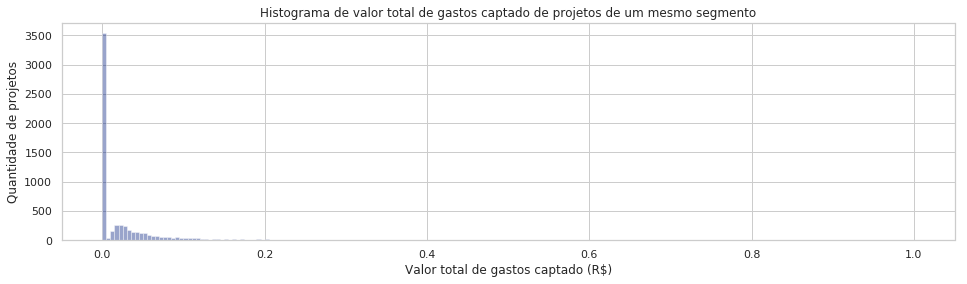

In [14]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(segment_projects, bins=200, kde=False)
plt.title('Histograma de porcentagem de preços de itens outliers de projetos de um mesmo segmento')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Porcentagem de preços de itens outliers')
plt.grid(True)

expected_mean = np.mean(segment_projects)
expected_std = np.std(segment_projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [15]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

idSegmento
11    0.016393
11    0.173913
11    0.000000
11    0.052632
11    0.510000
Name: percentage, dtype: float64

idSegmento
11    0.000000
11    0.000000
11    0.142857
11    0.000000
11    0.027778
Name: percentage, dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [16]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bin_factor = 0
    if len(inliers) > 0:
        bin_factor = (max(inliers) - min(inliers))
    bins = max(1, int(bin_factor // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        plt.plot(x,  bin_size * len(test_set) * model.model.pdf(x), label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('raised funds (R$)')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [17]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

## Modelo Gaussiano

Tempo de treinamento: 0.012 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 4.54%


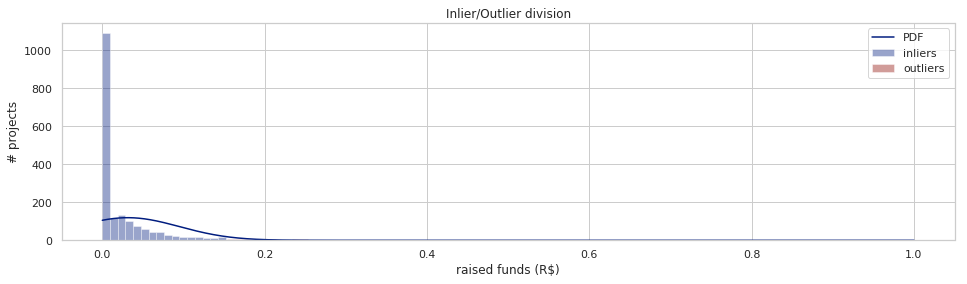

In [18]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=0.01)

## Modelo Log-normal

Tempo de treinamento: 0.004 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 60.81%


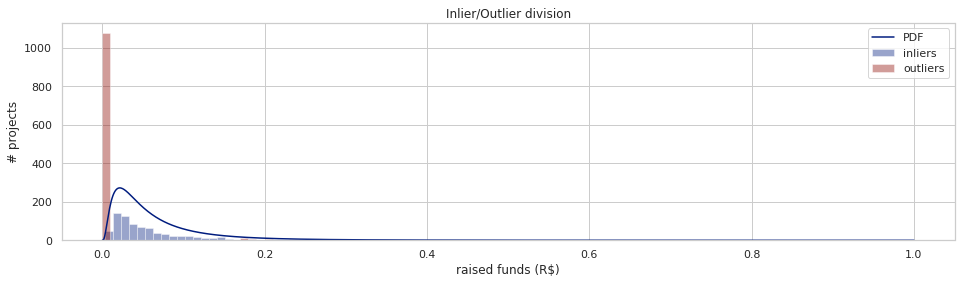

In [19]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        X = X[X > 0.0]
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(), projects_train, projects_test, bin_size=0.01)

## Modelo Gamma

Tempo de treinamento: 0.004 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 60.02%


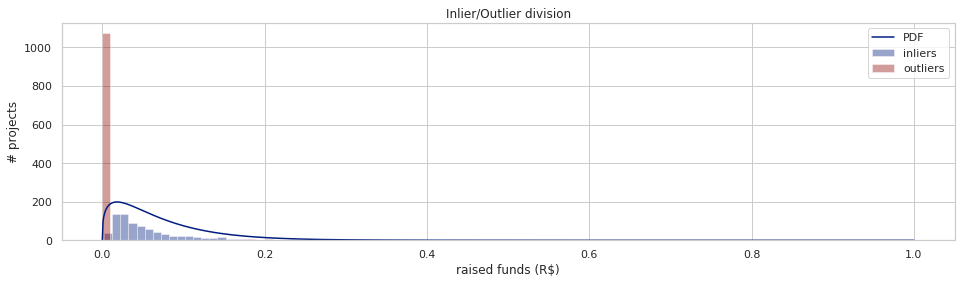

In [20]:
class Gamma:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        X = X[X > 0.0]
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=0.01)

## Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.532 (s)
Tempo de teste: 0.173 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 7.12%


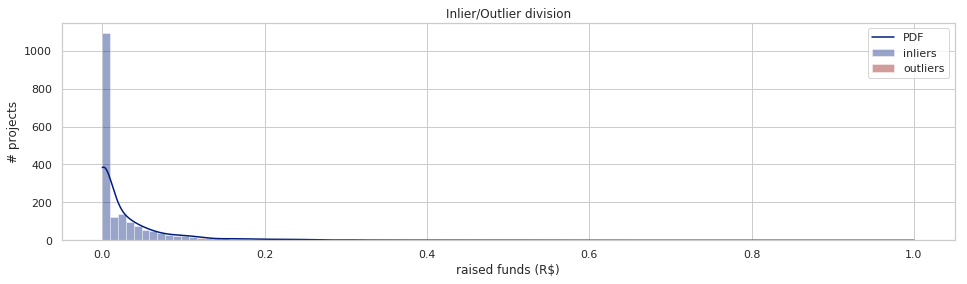

In [21]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=0.01)

## Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 5.263 (s)
Tempo de teste: 0.398 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 9.12%


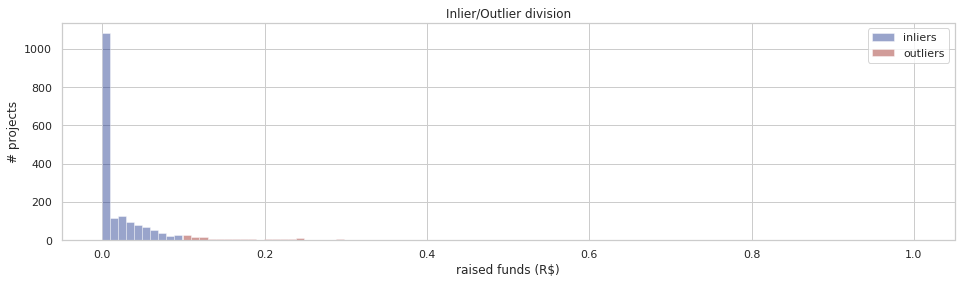

In [29]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=None):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        
        if self.n_neighbors == None:
            self.n_neighbors = len(X) // 2

        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=self.contamination, n_neighbors=self.n_neighbors)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(n_neighbors=2000), projects_train, projects_test, bin_size=0.01)

## Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [31]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(n_neighbors=2000),
    'results': []
}]

TEST_ITERATIONS = 100
train_elapsed_time = {}
test_elapsed_time = {}

for i in range(TEST_ITERATIONS):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        start_time = time.time()
        model['curve'] = model['curve'].fit(projects_train)
        ending_time = time.time()
        elapsed_time = ending_time - start_time
        
        model_name = model['name']
        train_elapsed_time.setdefault(model_name, 0.0)
        train_elapsed_time[model_name] += elapsed_time

        start_time = time.time()
        inlier_filter = model['curve'].predict(projects_test)
        ending_time = time.time()
        elapsed_time = ending_time - start_time

        model_name = model['name']
        test_elapsed_time.setdefault(model_name, 0.0)
        test_elapsed_time[model_name] += elapsed_time

        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)
        
for key in test_elapsed_time:
    print("Metric %s test elapsed time in seconds: %.4lf" % (key, test_elapsed_time[key]))
    print("Metric %s training elapsed time in seconds: %.4lf" % (key, train_elapsed_time[key]))

Metric Gaussian test elapsed time in seconds: 0.0308
Metric Gaussian training elapsed time in seconds: 0.4178
Metric Log-normal test elapsed time in seconds: 0.0429
Metric Log-normal training elapsed time in seconds: 0.5131
Metric Gamma test elapsed time in seconds: 0.0389
Metric Gamma training elapsed time in seconds: 0.4333
Metric KDE-Gauss test elapsed time in seconds: 19.5776
Metric KDE-Gauss training elapsed time in seconds: 9.9519
Metric LOF test elapsed time in seconds: 44.7058
Metric LOF training elapsed time in seconds: 579.2928


Média Gaussian: 4.65%
Média Log-normal: 60.06%
Média Gamma: 59.24%
Média KDE-Gauss: 7.07%
Média LOF: 9.12%


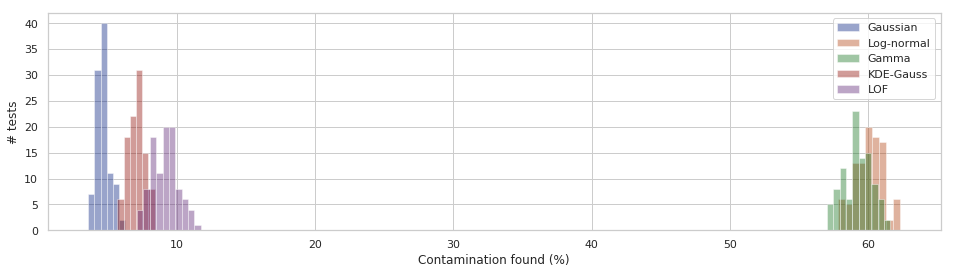

In [33]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.5
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)